# Scoring Review: Image inputs

In this notebook, we will demonstrate how to use imaging data as the reviewer inputs.

## Setting up the notebook

High-level configs

In [1]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv

# Load environment variables from .env file. Adjust the path to the .env file as needed.
load_dotenv(dotenv_path='../.env')

# Enable asyncio in Jupyter
import asyncio
import nest_asyncio

nest_asyncio.apply()

#  Add the package to the path (required if you are running this notebook from the examples folder)
import sys
sys.path.append('../../')

# Enable logging in litellm
import os
os.environ['LITELLM_LOG'] = 'DEBUG'


Import required packages

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
from tqdm.auto import tqdm


from lattereview.providers import LiteLLMProvider
from lattereview.providers import OllamaProvider
from lattereview.providers import OpenAIProvider
from lattereview.agents import ScoringReviewer
from lattereview.workflows import ReviewWorkflow

## Data

To check how imaging can be passed as input to the reviewers, we will create 9 random RGB images and also define a dummy task for the reviewer to output the digit with a random target color. We will create a dataframe that has the file path for each generated image, a randomly selected target color, and the ground truth number with that color based on the image. We will then pass this dataframe as our input to the reviewer agent.

100%|██████████| 9/9 [00:00<00:00, 131.19it/s]


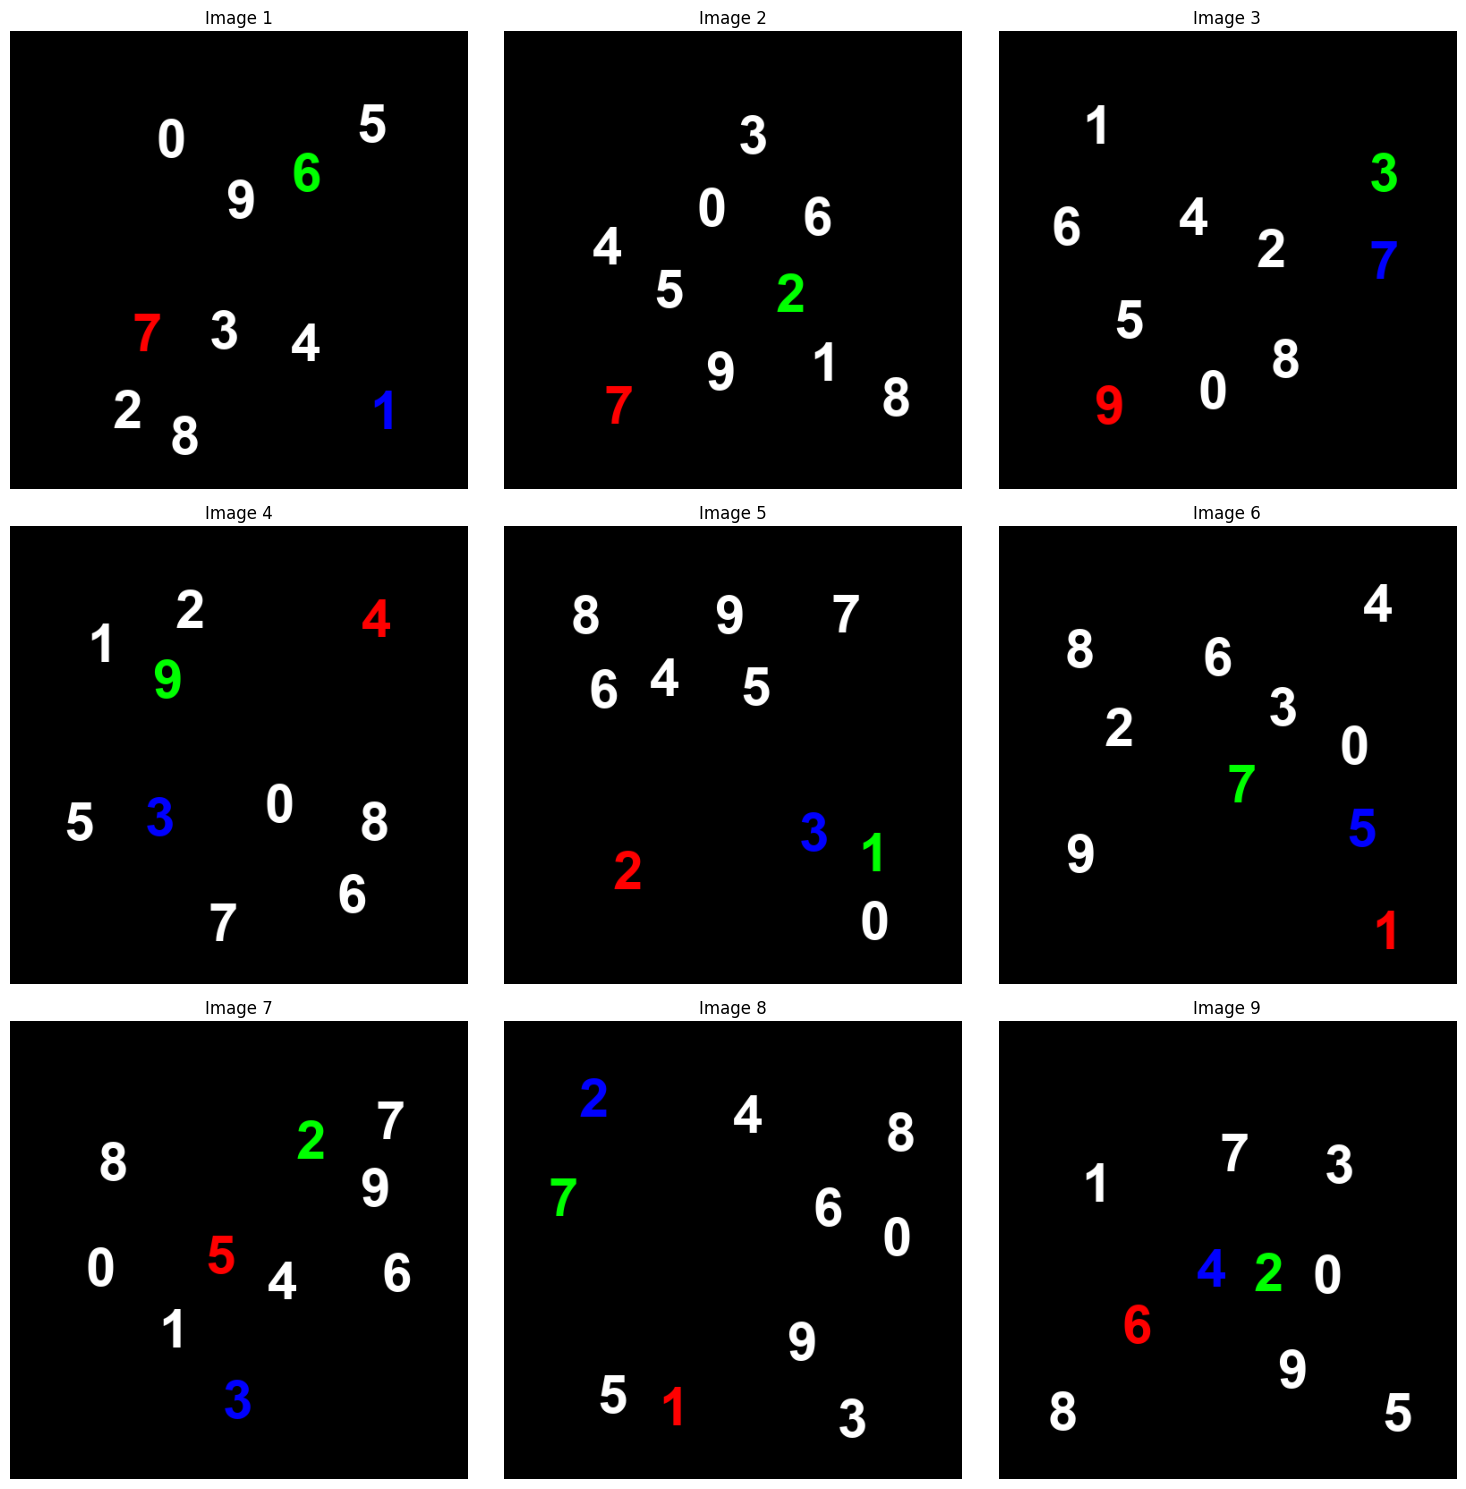


Generation complete!
Data saved to data/metadata.csv

Dataframe preview:
         image_path red_digit green_digit blue_digit target_color
0  data/image_0.jpg         7           6          1        green
1  data/image_1.jpg         7           2          2         blue
2  data/image_2.jpg         9           3          7          red
3  data/image_3.jpg         4           9          3        green
4  data/image_4.jpg         2           1          3          red
5  data/image_5.jpg         1           7          5         blue
6  data/image_6.jpg         5           2          3          red
7  data/image_7.jpg         1           7          2        green
8  data/image_8.jpg         6           2          4         blue


In [3]:
os.makedirs("data", exist_ok=True)

digits = list("0123456789")
colors = {
    "red": (255, 0, 0), 
    "green": (0, 255, 0), 
    "blue": (0, 0, 255), 
    "white": (255, 255, 255)
}
COLOR_NAMES = ["red", "green", "blue"]  # Available target colors

def check_overlap(new_bounds, existing_bounds):
    x1, y1, x2, y2 = new_bounds
    for ex1, ey1, ex2, ey2 in existing_bounds:
        padding = 30
        if not (x2 + padding < ex1 or x1 > ex2 + padding or 
                y2 + padding < ey1 or y1 > ey2 + padding):
            return True
    return False

def draw_digit(draw, digit, width, height, existing_bounds, color, max_attempts=100):
    padding = 50
    font = ImageFont.truetype("/Library/Fonts/Arial Bold.ttf", 60)
    
    for _ in range(max_attempts):
        bbox = draw.textbbox((0, 0), digit, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        x = random.randint(padding, width - text_width - padding)
        y = random.randint(padding, height - text_height - padding)
        bounds = (x, y, x + text_width, y + text_height)
        
        if not check_overlap(bounds, existing_bounds):
            existing_bounds.append(bounds)
            draw.text((x, y), digit, font=font, fill=color)
            return True
            
    return False

def create_image(width, height):
    max_attempts = 500
    
    for attempt in range(max_attempts):
        img = Image.new("RGB", (width, height), (0, 0, 0))
        draw = ImageDraw.Draw(img)
        existing_bounds = []
        
        # Randomly select three digits for red, green, and blue
        color_digits = {color: random.choice(digits) for color in COLOR_NAMES}
        
        # Randomly select a target color (will be red, green, or blue)
        target_color = random.choice(COLOR_NAMES)
        
        # Create color mapping for all digits
        color_mapping = {}
        for digit in digits:
            if digit in color_digits.values():
                # Find which color this digit is assigned to
                for color, d in color_digits.items():
                    if d == digit:
                        color_mapping[digit] = colors[color]
                        break
            else:
                color_mapping[digit] = colors["white"]
        
        # Try to place all digits
        all_digits_placed = True
        for digit in digits:
            if not draw_digit(draw, digit, width, height, existing_bounds, color_mapping[digit]):
                all_digits_placed = False
                break
        
        if all_digits_placed:
            return img, color_digits, target_color, True
            
    # If we couldn't place all digits after max attempts, return None
    return None, None, None, False

data = {
    "image_path": [],
    "red_digit": [],
    "green_digit": [],
    "blue_digit": [],
    "target_color": []
}

# Set figure parameters before creating the figure
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

# Image dimensions
width = 512
height = 512

for i in tqdm(range(9)):
    img, color_digits, target_color, success = create_image(width, height)
    
    if not success:
        print(f"Failed to create image {i+1} with all digits")
        continue
        
    image_path = f"data/image_{i}.jpg"
    img.save(image_path)
    
    data["image_path"].append(image_path)
    data["red_digit"].append(color_digits["red"])
    data["green_digit"].append(color_digits["green"])
    data["blue_digit"].append(color_digits["blue"])
    data["target_color"].append(target_color)
    
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i+1}", color='black')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

print("\nGeneration complete!")
data = pd.DataFrame(data)
data.to_csv("data/metadata.csv", index=False)
print("Data saved to data/metadata.csv")
print("\nDataframe preview:")
print(data)

## Scoring with image analysis
Passing images as input is straightforward. Simply specify the name of the DataFrame columns containing the image paths as `image_inputs` in your workflow schema. If needed, you can provide more than one image for each input item.

In [4]:
reviewer = ScoringReviewer(
    provider=LiteLLMProvider(model="gpt-4o-mini"),
    # provider = OpenAIProvider(model="gpt-4o"),
    # provider = OllamaProvider(model="llama3.2-vision:latest", host="http://localhost:11434"),
    name="reviewer",
    max_concurrent_requests=20, 
    backstory="An image reviewer",
    input_description="Images of digits",
    model_args={"max_tokens": 200, "temperature": 0.1},
    reasoning = "brief",
    scoring_task="Write the digit that has the target color in the provided image.",
    scoring_set=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    scoring_rules='Only write the digit that has the target color we are looking for.',
)

review = ReviewWorkflow(
    workflow_schema=[
        {
            "round": 'A',
            "reviewers": [reviewer],
            "text_inputs": ["target_color"],
            "image_inputs": ["image_path"] # This list could have len > 1 if more than one columns for imaging data exist in the dataframe.
        }
    ]
)

updated_data = asyncio.run(review(data))
updated_data


====== Starting review round A (1/1) ======

Processing 9 eligible rows


['round: A', 'reviewer_name: reviewer'] -                     2024-12-26 23:26:05: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]

The following columns are present in the dataframe at the end of reviewer's reivew in round A: ['image_path', 'red_digit', 'green_digit', 'blue_digit', 'target_color', 'round-A_reviewer_output', 'round-A_reviewer_reasoning', 'round-A_reviewer_score', 'round-A_reviewer_certainty']


,image_path,red_digit,green_digit,blue_digit,target_color,round-A_reviewer_output,round-A_reviewer_reasoning,round-A_reviewer_score,round-A_reviewer_certainty
0,data/image_0.jpg,7,6,1,green,{'reasoning': 'The digit that is colored green...,The digit that is colored green in the image i...,6,100
1,data/image_1.jpg,7,2,2,blue,{'reasoning': 'The image contains digits in va...,"The image contains digits in various colors, b...",0,90
2,data/image_2.jpg,9,3,7,red,{'reasoning': 'The digit '9' is the only one d...,The digit '9' is the only one displayed in red...,9,100
3,data/image_3.jpg,4,9,3,green,{'reasoning': 'The digit that is colored green...,The digit that is colored green in the image i...,9,100
4,data/image_4.jpg,2,1,3,red,{'reasoning': 'The digit '2' is the only digit...,The digit '2' is the only digit displayed in r...,2,100
5,data/image_5.jpg,1,7,5,blue,{'reasoning': 'The digit '5' is the only one d...,The digit '5' is the only one displayed in blu...,5,100
6,data/image_6.jpg,5,2,3,red,{'reasoning': 'The digit '5' is the only one d...,The digit '5' is the only one displayed in red...,5,100
7,data/image_7.jpg,1,7,2,green,{'reasoning': 'The digit '7' is the only digit...,The digit '7' is the only digit displayed in g...,7,100
8,data/image_8.jpg,6,2,4,blue,{'reasoning': 'The digit that is colored blue ...,The digit that is colored blue in the image is...,4,100
